First, I will look at the f3 statistic for the two anubis clusters and hamadryas

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

In [3]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_01_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

Picking the ID values, and then extracting the allele counts.

In [4]:
meta_data_samples_f = meta_data_samples.loc[meta_data_samples.Sex=="F"]
anubis_t = meta_data_samples_f.loc[meta_data_samples_f.C_origin=="Anubis, Tanzania"].callset_index.values
anubis_e = meta_data_samples_f.loc[meta_data_samples_f.C_origin=="Anubis, Ethiopia"].callset_index.values
hamadryas = meta_data_samples_f.loc[meta_data_samples_f.C_origin=="Hamadryas, Ethiopia"].callset_index.values

In [5]:
a_t_gt = gt.take(anubis_t, axis=1)
a_e_gt = gt.take(anubis_e, axis=1)
h_gt = gt.take(hamadryas, axis=1)

In [6]:
a_t_ac = a_t_gt.count_alleles(max_allele=1)
a_e_ac = a_e_gt.count_alleles(max_allele=1)
h_ac = h_gt.count_alleles(max_allele=1)

If there is no data in one species, f3 seems to fail (division by zero), so I remove all sites which has at least one part failing.

In [7]:
passing_sites = (a_t_ac.max_allele() >= 0) & (a_e_ac.max_allele() >= 0) & (h_ac.max_allele() >= 0)

In [8]:
passing_sites.sum(), len(passing_sites)

(2917429, 2923212)

In [9]:
a_tanza = a_t_ac.compress(passing_sites)
a_ethio = a_e_ac.compress(passing_sites)
hama = h_ac.compress(passing_sites)

In [10]:
a_ethio

<AlleleCountsArray shape=(2917429, 2) dtype=int32>
 9  5
13  1
13  3
...
15  1
16  0
 2 12

Running f3 to understand it

In [11]:
allel.average_patterson_f3(a_tanza, hama, a_ethio, blen=200000)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/allel/stats/admixture.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = (ac[:, 0] * ac[:, 1]) / (an * (an - 1))


(0.0033220321719259834,
 0.001911566173410367,
 1.7378588395918553,
 array([ 0.00983998,  0.00239837, -0.00310992,  0.00653446, -0.00028258,
         0.00559179, -0.00419462,  0.01620842,  0.01295266,  0.01023891,
        -0.00464308, -0.0038502 , -0.00663959,  0.00314143]),
 array([0.00275146, 0.00363458, 0.00397864, 0.00331653, 0.0038246 ,
        0.00338791, 0.00407011, 0.00265646, 0.00282197, 0.00301654,
        0.00411022, 0.00406228, 0.00425344, 0.00356539]))

In [12]:
window_f3 = allel.moving_patterson_f3(a_ethio, a_tanza, hama, size=100000)
window_f3.sum()/len(window_f3)

0.06256437130714967

In [13]:
window_f3

array([0.02680968, 0.01901463, 0.02685012, 0.05070943, 0.08008943,
       0.06736456, 0.11325105, 0.05080349, 0.06946956, 0.05867349,
       0.05673762, 0.06799025, 0.1034984 , 0.06253626, 0.06768592,
       0.05535065, 0.05154545, 0.04433469, 0.04278694, 0.04034686,
       0.06662292, 0.07922641, 0.06320956, 0.08574693, 0.08289608,
       0.08554571, 0.06460797, 0.0609955 , 0.06966719])

Even though this seems to have variuos pitfalls, I will calculate f3 for each chrom and then compare them.
It is both an option to compare f3 and the Z-score.

In [14]:
chromosomes = ['chr{}'.format(x) for x in range(1, 21)] + ['chrX']
f3_list = []
z_list = []
size_list = []
for chrom in chromosomes:
    zarr_dir = f"/faststorage/project/baboondiversity/data/PG_panu3_zarr_01_03_2021/callset.zarr/{chrom}"
    callset = zarr.open_group(zarr_dir, mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    a_t_gt = gt.take(anubis_t, axis=1)
    a_e_gt = gt.take(anubis_e, axis=1)
    h_gt = gt.take(hamadryas, axis=1)
    a_t_ac = a_t_gt.count_alleles(max_allele=1)
    a_e_ac = a_e_gt.count_alleles(max_allele=1)
    h_ac = h_gt.count_alleles(max_allele=1)
    passing_sites = (a_t_ac.max_allele() >= 0) & (a_e_ac.max_allele() >= 0) & (h_ac.max_allele() >= 0)
    a_tanza = a_t_ac.compress(passing_sites)
    a_ethio = a_e_ac.compress(passing_sites)
    hama = h_ac.compress(passing_sites)
    f3_stats = allel.average_patterson_f3(a_tanza, hama, a_ethio, blen=200000)
    f3_list.append(f3_stats[0])
    z_list.append(f3_stats[2])
    size_list.append(callset["variants/POS"][-1])
d={"f3": f3_list, "Z": z_list, "chrsize": size_list, "chr": chromosomes}
f3_df = pd.DataFrame(data=d)

In [15]:
f3_df["chromtype"] = np.where(f3_df.chr=="chrX", "chrX", "autosome")

<AxesSubplot:xlabel='Z', ylabel='f3'>

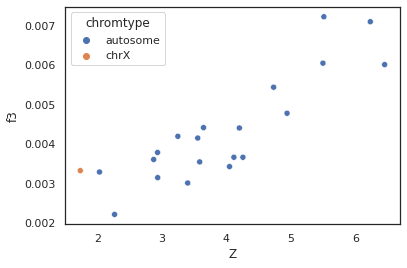

In [16]:
sns.scatterplot(data=f3_df, x="Z", y="f3", hue="chromtype")

<AxesSubplot:xlabel='f3', ylabel='chrsize'>

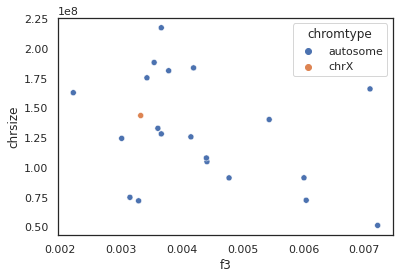

In [17]:
sns.scatterplot(data=f3_df, x="f3", y="chrsize", hue="chromtype")

<AxesSubplot:xlabel='Z', ylabel='Count'>

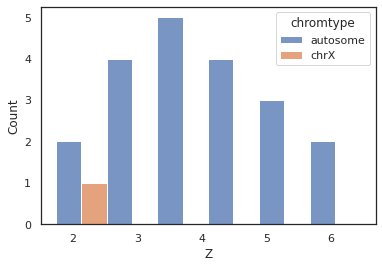

In [18]:
sns.histplot(data=f3_df, x="Z", hue="chromtype", multiple="dodge")